In [1]:
import pandas as pd
import os
from datetime import datetime as dt

from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import pycountry as pc

import warnings
warnings.filterwarnings('ignore')

In [2]:
# classification targets
target_conf = 'armedconf'
target_escl = 'escalation'

# regression target
target_regr = 'deaths_all_pc'

# many features are made per-country
unit_of_analyis = 'isocode'

# start and end of test set
start_month_year = dt(2018, 1, 1)
end_month_year = dt(2023, 3, 1)

# time horizons forecase for
fwds = [1,3,6]

# target groupings
clsf_targets = [target_conf, target_escl]
regr_targets = [target_regr]

all_targets = clsf_targets + regr_targets

# algorithms used
algos = ['rf', 'xgb']

## Import predictions and join with true values

In [3]:
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

### Re-create targets

Generated from all data, so need to drop training data.

In [4]:
df_og = pd.read_csv(os.path.abspath(parent_path + '/data/preprocessed_df.csv'))

df_og['month_year'] = pd.to_datetime(df_og['month_year'])

print(df_og.shape)
print(df_og.month_year.min(), df_og.month_year.max())
df_og.head()

(54915, 88)
2000-01-01 00:00:00 2023-03-01 00:00:00


,isocode,month_year,month,year,Country Name,deaths_all_pc,armedconf,escalation,past6,past12,...,isocode_4,isocode_5,isocode_6,isocode_7,f3_target_escl,f6_target_escl,f3_target_clsf,f6_target_clsf,f3_target_regr,f6_target_regr
0,AFG,2000-01-01,1,2000,Afghanistan,0.276314,True,0,0.276314,0.276314,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,2000-02-01,2,2000,Afghanistan,0.777290,True,1,1.053604,1.053604,...,0,0,0,1,1.0,1.0,1.0,1.0,1.701424,1.600231
2,AFG,2000-03-01,3,2000,Afghanistan,1.620053,True,0,2.673657,2.673657,...,0,0,0,1,0.0,1.0,1.0,1.0,1.581843,2.404725
3,AFG,2000-04-01,4,2000,Afghanistan,2.706927,True,0,5.380585,5.380585,...,0,0,0,1,0.0,1.0,1.0,1.0,1.160851,3.083456
4,AFG,2000-05-01,5,2000,Afghanistan,0.418548,True,0,5.799133,5.799133,...,0,0,0,1,1.0,1.0,1.0,1.0,1.499038,2.822271


In [5]:
def make_target_clsf(df: pd.DataFrame, shifter: int, target: str):

    # loop through each period and generate the shift variables (name doesn't matter, just interim columns to take max)
    for i in range(1, shifter+1):
        col_name = f'{target}{i}'
        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the maximum for t periods forward and create the new variable & drop the shift variables
    df[f'{target}_f{shifter}'] = df[[f'{target}{i}' for i in range(1, shifter+1)]].max(axis=1, skipna=False)
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)


def make_target_regr(df: pd.DataFrame, shifter: int, target: str): 

    # loop through each period and generate the temporary shift variables
    for i in range(1, shifter+1):
        col_name = f'{target}{i}'
        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the mean for t periods forward and create the new variable &
    df[f'{target}_f{shifter}'] = df[[f'{target}{i}' for i in range(1, shifter+1)]].mean(axis=1, skipna=False)

    # 
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)

In [6]:
# demonstrating the make_target functions
df_targets = df_og.copy()

# generate targets
for fwd in fwds:
    for target in clsf_targets:
        df_targets = make_target_clsf(df_targets, fwd, target)
    
    for target in regr_targets:
        df_targets = make_target_regr(df_targets, fwd, target)

# check it worked
fwd = 3
df_targets.loc[df_targets['isocode'] == 'BFA', ['isocode', 'Country Name', 'month_year',  'armedconf',  f'{target_escl}_f{fwd}', f'{target_conf}_f{fwd}','deaths_all_pc', f'{target_regr}_f{fwd}']][-8:]

,isocode,Country Name,month_year,armedconf,escalation_f3,armedconf_f3,deaths_all_pc,deaths_all_pc_f3
43378,BFA,Burkina Faso,2022-08-01,True,0.0,1.0,1.475068,0.754125
43379,BFA,Burkina Faso,2022-09-01,True,0.0,1.0,0.868751,0.758649
43380,BFA,Burkina Faso,2022-10-01,True,0.0,1.0,0.475098,0.600283
43381,BFA,Burkina Faso,2022-11-01,True,1.0,1.0,0.918524,1.010527
43382,BFA,Burkina Faso,2022-12-01,True,1.0,1.0,0.882326,1.561038
43383,BFA,Burkina Faso,2023-01-01,False,NaN,NaN,0.000000,NaN
43384,BFA,Burkina Faso,2023-02-01,True,NaN,NaN,2.149255,NaN
43385,BFA,Burkina Faso,2023-03-01,True,NaN,NaN,2.533858,NaN


In [7]:
df_targets = df_targets.loc[df_targets['month_year'] >= start_month_year]

print(df_targets.shape)
df_targets.columns

(12411, 97)


Index(['isocode', 'month_year', 'month', 'year', 'Country Name',
       'deaths_all_pc', 'armedconf', 'escalation', 'past6', 'past12', 'past60',
       'past120', 'armedconf_since', 'deaths_stock', 'share_events_1',
       'share_events_2', 'share_events_3', 'share_events_4', 'share_events_5',
       'share_events_6', 'share_events_7', 'share_events_8', 'share_events_9',
       'share_events_10', 'share_events_11', 'share_events_12',
       'share_events_13', 'share_events_14', 'share_events_15',
       'share_events_16', 'share_events_17', 'share_events_18',
       'share_events_19', 'share_events_20', 'share_events_gov',
       'share_events_opp', 'norm_total_events', 'event_share_1_stock',
       'event_share_2_stock', 'event_share_3_stock', 'event_share_4_stock',
       'event_share_5_stock', 'event_share_6_stock', 'event_share_7_stock',
       'event_share_8_stock', 'event_share_9_stock', 'event_share_10_stock',
       'event_share_11_stock', 'event_share_12_stock', 'event_share_1

### Import predictions

All are joined into a single data frame.

In [8]:
df_preds = pd.read_csv(os.path.abspath(path + f'/tree_based_predictions/Final/predictions_rf_f1_escalation.csv'))
df_preds = df_preds[['isocode', 'month_year']]
df_preds['month_year'] = pd.to_datetime(df_preds['month_year'])

print(df_preds.shape, df_targets.shape)
print(df_preds.month_year.min(), df_preds.month_year.max())
print(df_targets.month_year.min(), df_targets.month_year.max())

df_preds.head()

(12411, 2) (12411, 97)
2018-01-01 00:00:00 2023-03-01 00:00:00
2018-01-01 00:00:00 2023-03-01 00:00:00


,isocode,month_year
0,AFG,2018-01-01
1,AGO,2018-01-01
2,ALB,2018-01-01
3,ARE,2018-01-01
4,ARG,2018-01-01


In [9]:
for algo in algos:
    for fwd in fwds:
        for target in all_targets: # all_targets

            df_temp = pd.read_csv(os.path.abspath(path + f'/tree_based_predictions/Final/predictions_{algo}_f{fwd}_{target}.csv'))
            df_temp.drop(columns=['Unnamed: 0'], inplace=True)
            
            df_temp['month_year'] = pd.to_datetime(df_temp['month_year'], format='%Y-%m-%d')
            df_temp.sort_values(by=['month_year', 'isocode'], inplace=True)
            
            print(df_temp.shape, df_temp.month_year.min(), df_temp.month_year.max())
            
            #print(df_temp.columns )
            #df_preds = pd.concat([df_preds, df_temp], axis=1)

            df_preds = df_preds.merge(df_temp, how='left', on=['isocode', 'month_year'])

(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00


In [10]:
df_preds = df_preds.loc[:,~df_preds.T.duplicated(keep='first')]

print(df_preds.shape)
#df_preds.columns
df_preds.head(2)

(12411, 56)


,isocode,month_year,pred_armedconf_rf_f1_all,pred_armedconf_rf_f1_hs,pred_armedconf_rf_f1_tx,pred_escalation_rf_f1_all,pred_escalation_rf_f1_hs,pred_escalation_rf_f1_tx,pred_deaths_all_pc_rf_f1_all,pred_deaths_all_pc_rf_f1_hs,...,pred_deaths_all_pc_xgb_f3_tx,pred_armedconf_xgb_f6_all,pred_armedconf_xgb_f6_hs,pred_armedconf_xgb_f6_tx,pred_escalation_xgb_f6_all,pred_escalation_xgb_f6_hs,pred_escalation_xgb_f6_tx,pred_deaths_all_pc_xgb_f6_all,pred_deaths_all_pc_xgb_f6_hs,pred_deaths_all_pc_xgb_f6_tx
0,AFG,2018-01-01,0.988908,0.991190,0.958227,0.405951,0.114284,0.763412,11.127582,11.223889,...,3.572988,1.000000,0.999882,1.000000,0.989187,0.997928,0.999490,2.151273,2.929380,2.874567
1,AGO,2018-01-01,0.210516,0.235263,0.351255,0.608128,0.714963,0.314381,0.009906,0.008070,...,0.153685,0.017353,0.001365,0.025607,0.998660,0.984795,0.991863,0.192119,0.187882,0.188585


In [11]:
print('armed conflicts:', df_og[target_conf].sum())
print('perc of observ.:', df_og[target_conf].sum()/len(df_og)*100)

## with old preprocessing
# armed conflicts: 7144
# perc of observ.: 8.94397496087637

armed conflicts: 4594
perc of observ.: 8.36565601383957


### Join targets & predictions

Single data frame from which to generate metrics.

In [19]:
df_targ = df_targets.copy()
df_pred = df_preds.copy()

In [20]:
df_targ.sort_values(by=['month_year', 'isocode'], inplace=True)
df_targ.reset_index(drop=True, inplace=True)
df_targ['month_year'] = pd.to_datetime(df_targ['month_year'], format='%Y-%m-%d')

In [21]:
# important to reset indices so that concatenation does not genrate additional rows
df_targ.reset_index(inplace=True) 
df_pred.reset_index(inplace=True)

# check same length
print(df_targ.shape, df_pred.shape)

# concatenate the two dataframes
#df_joined = pd.concat([df_targ, df_pred], axis=1)
df_joined = df_targ.merge(df_pred, how='left', on=['isocode', 'month_year'])

df = df_joined.copy()

df = df.loc[:,~df.T.duplicated(keep='first')]
df.drop(columns=['index_x'], inplace=True)

print(df.shape)
df.head(2)

(12411, 98) (12411, 57)
(12411, 151)


,isocode,month_year,month,year,Country Name,deaths_all_pc,armedconf,escalation,past6,past12,...,pred_deaths_all_pc_xgb_f3_tx,pred_armedconf_xgb_f6_all,pred_armedconf_xgb_f6_hs,pred_armedconf_xgb_f6_tx,pred_escalation_xgb_f6_all,pred_escalation_xgb_f6_hs,pred_escalation_xgb_f6_tx,pred_deaths_all_pc_xgb_f6_all,pred_deaths_all_pc_xgb_f6_hs,pred_deaths_all_pc_xgb_f6_tx
0,AFG,2018-01-01,1,2018,Afghanistan,4.838255,True,1,30.689119,55.771793,...,3.572988,1.000000,0.999882,1.000000,0.989187,0.997928,0.999490,2.151273,2.929380,2.874567
1,AGO,2018-01-01,1,2018,Angola,0.000000,False,0,0.012864,0.085440,...,0.153685,0.017353,0.001365,0.025607,0.998660,0.984795,0.991863,0.192119,0.187882,0.188585


## Metrics helper functions

In [23]:
# Allows us to obtain the predictions for a given target and original shifted data

def get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str, algo: str):
    
    target_col = f'{target}_f{fwd}'
    pred_col = f'pred_{target}_{algo}_f{fwd}_{model}'

    df = df[[unit_of_analyis, 'month_year', target_col, pred_col]] 
    #df['month_year'] = pd.to_datetime(df['date_str'])
    #df = df[df.month_year >= start_time]
    df = df.dropna()

    y_preds = df[pred_col]
    y_trues = df[target_col]

    return y_trues, y_preds

In [32]:
# different levels forward will have different shapes due to NaN values being dropped
exmpl_df = pd.DataFrame(get_tar_pred(df, 6, 'tx', start_month_year, target_conf, 'rf'))

print(exmpl_df.shape)
#exmpl_df.head(2)

(2, 11229)


In [33]:
def get_roc_pr(df_og: pd.DataFrame, fwd: int, target: str, models: list, staryearid, algo = str): #binary=True, plot=True
    """Function to return the roc and pr values for a given target, level and forward period"""
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    for model in models:

        y_true, y_pred = get_tar_pred(df=df_og, fwd=fwd, model=model,start_time=staryearid, target=target,
                                        algo = algo)
    
        roc = roc_auc_score(y_true, y_pred)
        pr = average_precision_score(y_true, y_pred)
    
        # Compute the FPR & TPR and calculate the AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        y_pred_binary = (y_pred > 0.5).astype(int)
        # Compute precision, recall, and thresholds for PR curve
        precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred)
    
        print('Model:', model)
        print('ROC:', round(roc, 3), 'Precision:', round(pr, 3))
        
        # Generate classification report
        class_report = classification_report(y_true, y_pred_binary)
        print('\nClassification Report:\n', class_report)
    
        # Plot ROC curve
        axs[0].plot(fpr, tpr, lw=2, label=f'ROC curve {model} (area = {roc_auc:.2f})')
    
        # Plot precision-recall curve
        axs[1].plot(recall, precision, lw=2, label=f'Precision-Recall curve {model} (prec: {pr:.2f})')
    
        axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[0].set_xlim([0.0, 1.0])
        axs[0].set_ylim([0.0, 1.05])
        axs[0].set_xlabel('False Positive Rate (FP/(FP+TN))')
        axs[0].set_ylabel('True Positive Rate/Recall (TP/(TP+FN))')
        axs[0].set_title(f'ROCs for {target} {fwd} month(s) ahead')
        axs[0].legend(loc="lower right")
        
        axs[1].set_xlabel('Recall (TP/(TP+FN))')
        axs[1].set_ylabel('Precision (TP/(TP+FP))')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend(loc="lower left")
        
        plt.tight_layout()
    plt.show()


## ROC and precision re-call curves (for classification)

TARGET: armedconf f1
Model: all
ROC: 0.983 Precision: 0.904

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     10962
         1.0       0.90      0.78      0.83      1252

    accuracy                           0.97     12214
   macro avg       0.94      0.88      0.91     12214
weighted avg       0.97      0.97      0.97     12214

Model: tx
ROC: 0.972 Precision: 0.854

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     10962
         1.0       0.90      0.62      0.73      1252

    accuracy                           0.95     12214
   macro avg       0.93      0.80      0.85     12214
weighted avg       0.95      0.95      0.95     12214

Model: hs
ROC: 0.983 Precision: 0.905

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     10962
         1.0       0.89   

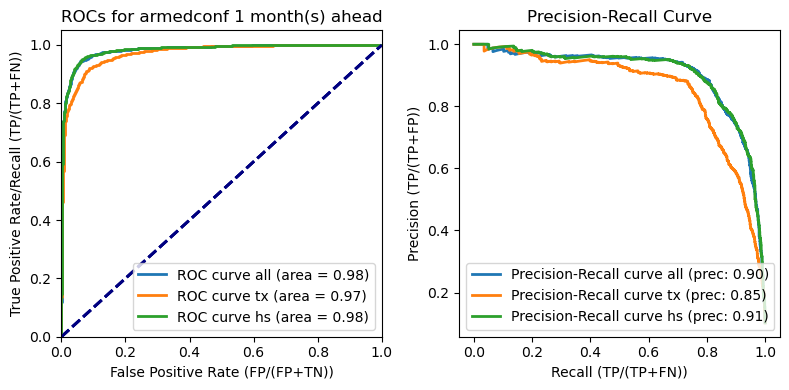

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f3
Model: all
ROC: 0.974 Precision: 0.914

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     10225
         1.0       0.86      0.79      0.83      1595

    accuracy                           0.96     11820
   macro avg       0.92      0.89      0.90     11820
weighted avg       0.95      0.96      0.95     11820

Model: tx
ROC: 0.951 Precision: 0.832

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     10225
         1.0       0.85      0.65      0.74      1595

    accuracy                           0.94     11820
   macro avg       0.90      0.82      0.85     11820
weighted avg       0.93      0.94      0.93     11820

Model: hs
ROC: 0.976 Precision: 0.922

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97   

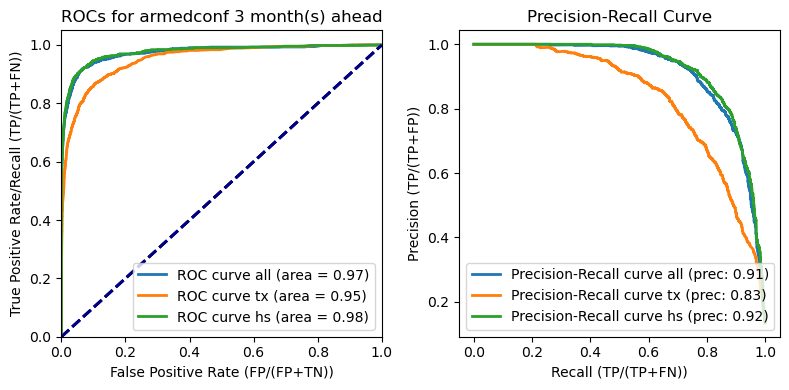

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f6
Model: all
ROC: 0.956 Precision: 0.888

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      9429
         1.0       0.88      0.76      0.82      1800

    accuracy                           0.95     11229
   macro avg       0.92      0.87      0.89     11229
weighted avg       0.94      0.95      0.94     11229

Model: tx
ROC: 0.951 Precision: 0.859

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      9429
         1.0       0.87      0.68      0.76      1800

    accuracy                           0.93     11229
   macro avg       0.90      0.83      0.86     11229
weighted avg       0.93      0.93      0.93     11229

Model: hs
ROC: 0.962 Precision: 0.891

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96   

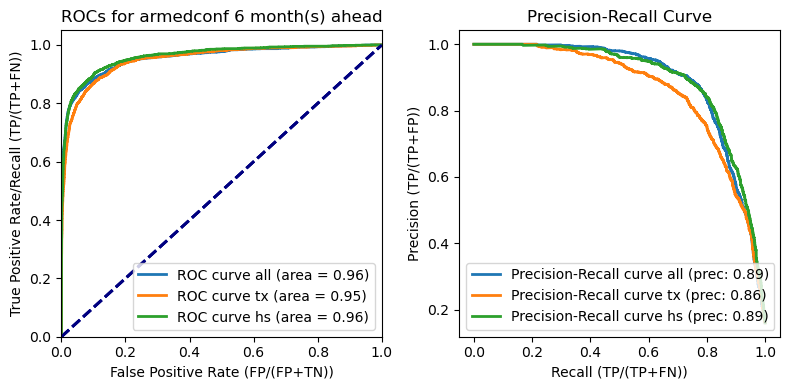

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [42]:
for target in ['armedconf']:
    for sft in [1,3,6]: #,2]:
        print('TARGET:', target, f'f{sft}') #, model)
        get_roc_pr(df, sft, target, ['all', 'tx', 'hs'], start_month_year, algo = 'xgb')
        print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

In [34]:
def separation_plot(pdata, fname, alpha=1):
    '''
    Display observed events against predicted probabilities for binary classification problems
    Arguments
    ---------
        y : vector of observed class labels
        yhat : vector of predicted probabilities
        fname: file path to directory to save plot 
        alpha: float from 0 to 1, transparency of indicators of observed events
    '''

    pdata.columns = ['y', 'yhat']
    pdata = pdata.sort_values('yhat')
    pdata = pdata.reset_index(drop=True)

    events = pdata[pdata['y'] == 1]
    evals = events.index.values

    plt.figure(figsize=(20, 5))
    plt.ylabel('Predicted risk')
    ax = plt.gca()
    ax.set_xlim([1, (evals[-1] + 1)])
    ax.set_ylim([0, 1])
    
    rr = 0
    for i in evals:
        if rr == 0:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, label = 'Increases', zorder=2)
            rr = 1
        else:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, zorder=1)
    
    ax.plot(pdata['yhat'], linestyle='--', color='red', lw = 4, label = 'Predicted increase', zorder=3)
    ax.set_xlabel('Rank of prediction')
    ax.legend(loc="upper left")
    #plt.savefig(fname)
    plt.show()
    plt.close() 

## Separation Plots (for classification)

Could be adapted for months since.

In [35]:
#monthsince as the key sufficient statistic - make sure you understand

def produce_stats(df, true_vals, pred_vals): #monthsince

    #drop any rows for which there are no predictions
    restricted=df.dropna(subset=[true_vals,f'{pred_vals}_all', f'{pred_vals}_hs', f'{pred_vals}_tx'])
    
    # IGNORED
    #only keep observations where there has been at least (0) months of peace
    #restricted=restricted[restricted["anyviolence_dp"]>=monthsince] #anyviolence_dp counts months of peace duration
    
    y_true=restricted[true_vals]

    # full model
    #y_scores=restricted[f'{pred_vals}_all']
    #print("observations:", len(y_scores))
    #print("full model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_all']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # history model
    #y_scores=restricted[f'{pred_vals}_hs']
    #print("history model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_hs']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # text model
    #y_scores=restricted[f'{pred_vals}_tx']
    #print("text model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_tx']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # Print separation plots
    print("")

    print('Full model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_all']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')

    print('History model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_hs']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')

    print('Text model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_tx']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')
    

-----------------------------------------------------------------------------------------
STATISTICS FOR TAGRET armedconf, predicting 1 month(s) ahead

Full model separation plot:


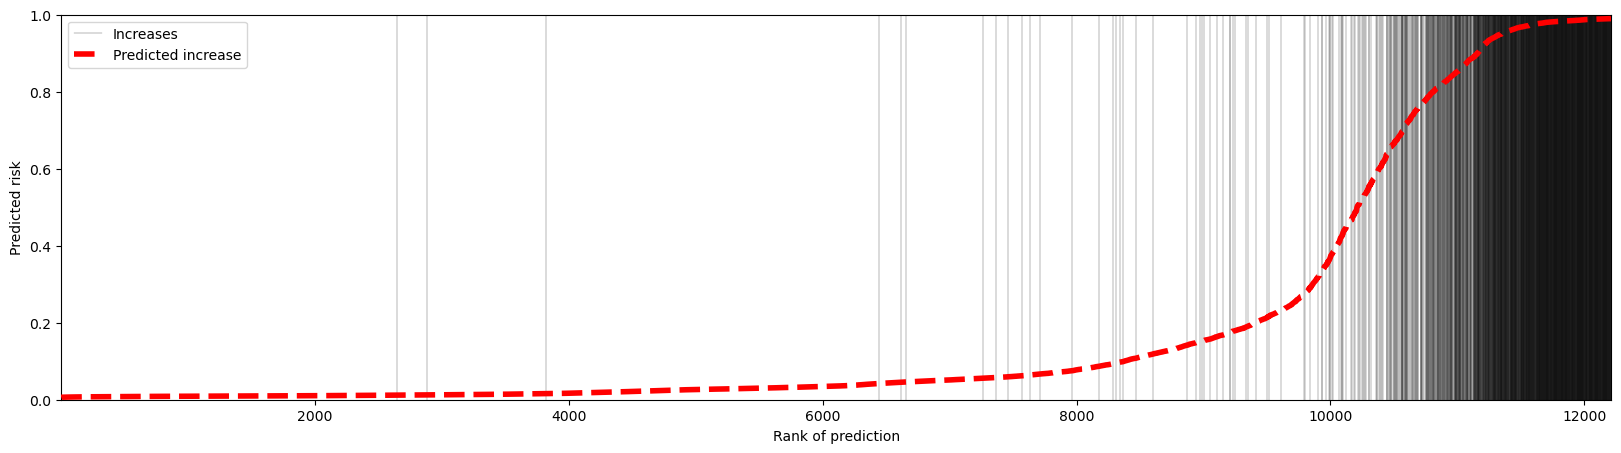

History model separation plot:


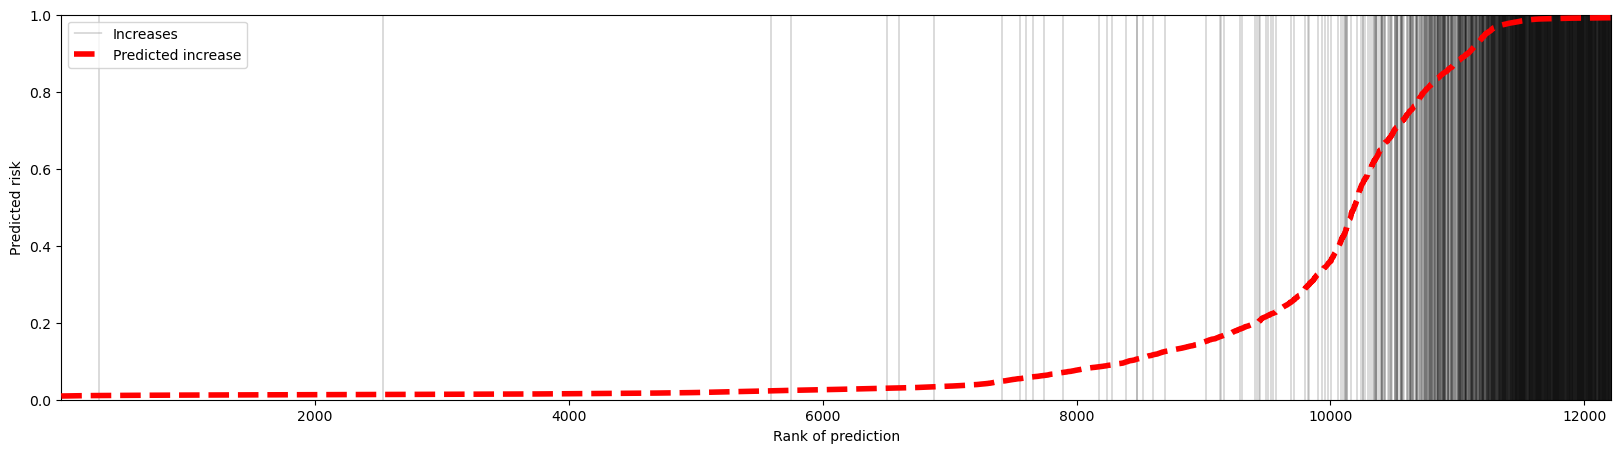

Text model separation plot:


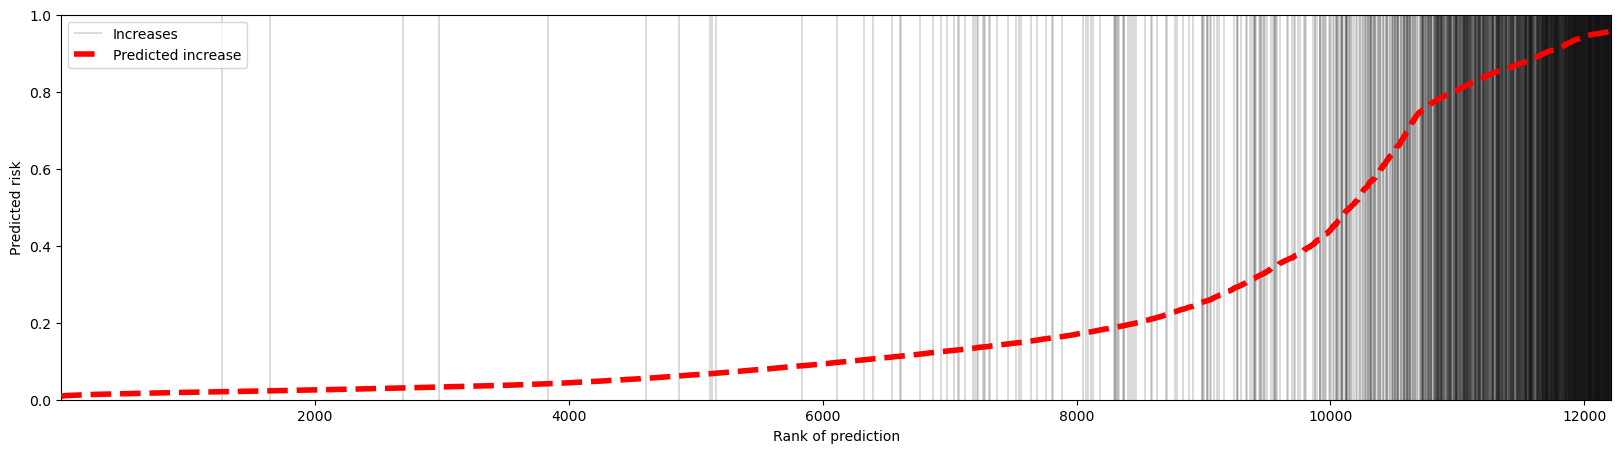

In [40]:
plot_targtes = ['armedconf']
plot_ffwds = [1]

algo = 'rf'
for target in plot_targtes:
    for forward in plot_ffwds:
        print('-----------------------------------------------------------------------------------------')
        print(f'STATISTICS FOR TAGRET {target}, predicting {forward} month(s) ahead')
        produce_stats(df, f'{target}_f{forward}', f'pred_{target}_{algo}_f{forward}')

## Root mean squared error (for regression)

In [65]:
fwds = [1,3,6]
models = ['all', 'hs', 'tx']

start_date = start_month_year #start_date ##start_date = dt.datetime(2018, 1, 2)

errors = {}

for algo in algos: 
    print('ALGORITHM:', algo)
    
    for model in models:

        for fwd in fwds:
                
                # get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str, algo: str):
                y_trues, y_preds = get_tar_pred(df, fwd, model, start_date, target_regr, algo)
            
                errors[f'{model}_{fwd}'] = mean_squared_error(y_trues, y_preds)

    print('All Root Mean Squared Errors:')
    print(pd.Series(errors)) #.sort_values()

ALGORITHM: rf
All Root Mean Squared Errors:
all_1    0.623561
all_3    0.494066
all_6    0.374951
hs_1     0.620274
hs_3     0.490628
hs_6     0.372199
tx_1     0.957990
tx_3     0.717658
tx_6     0.590892
dtype: float64
ALGORITHM: xgb
All Root Mean Squared Errors:
all_1    0.631231
all_3    0.418932
all_6    0.339972
hs_1     0.587219
hs_3     0.405162
hs_6     0.352180
tx_1     0.860619
tx_3     0.623758
tx_6     0.511467
dtype: float64


## Plots by country for inspection

In [ ]:
# pick country, forecast horizon and model
country = 'SSD' #'SSD'
forward = 1

# get country df
country_name = pc.countries.get(alpha_3=country)
country_clsf =  df[df.isocode == country]

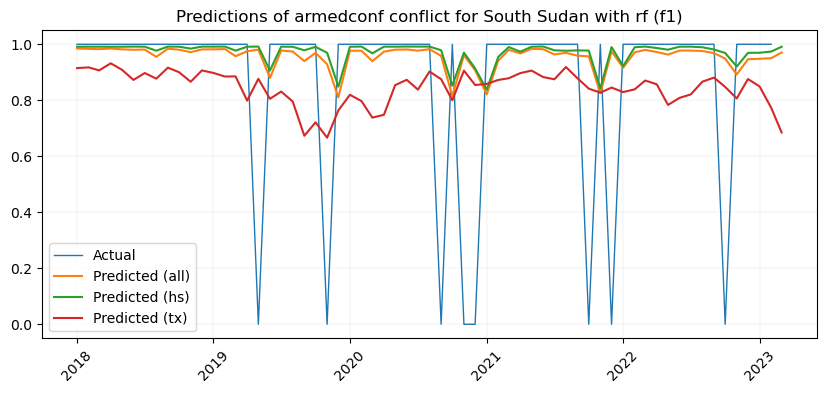

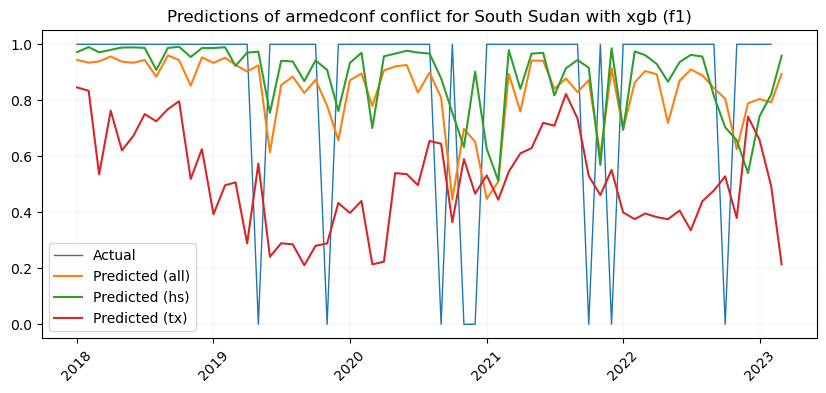

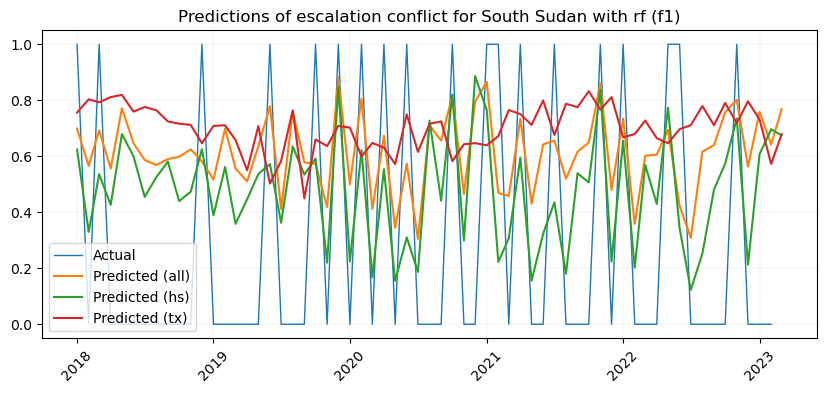

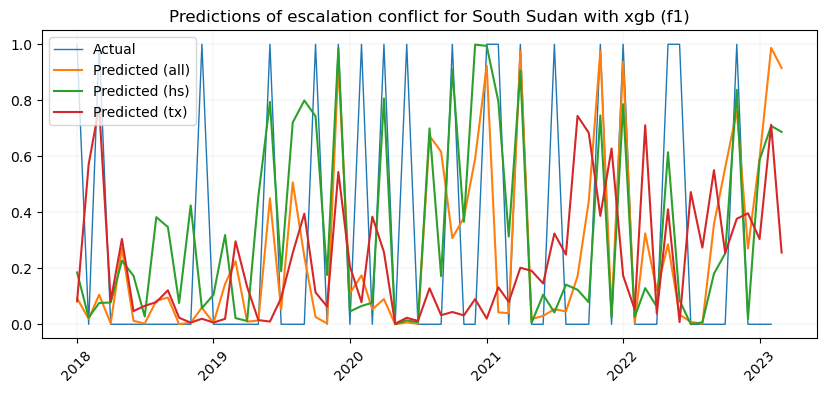

In [73]:
# plots for classification targets
for target in clsf_targets:
    for algo in algos:
        plt.figure(figsize=(10,4))

        plt.plot(country_clsf.month_year,country_clsf[f'{target}_f{forward}'], linewidth=1, label = 'Actual')

        for model in ['all', 'hs', 'tx']:
            plt.plot(country_clsf.month_year,country_clsf[f'pred_{target}_{algo}_f{forward}_{model}'], label = f'Predicted ({model})')

        plt.title(f'Predictions of {target} conflict for {country_name.name} with {algo} (f{forward})')
        plt.legend()
        plt.grid(color='grey', linestyle='--', linewidth=0.1)
        plt.xticks(rotation=45)
        plt.show()

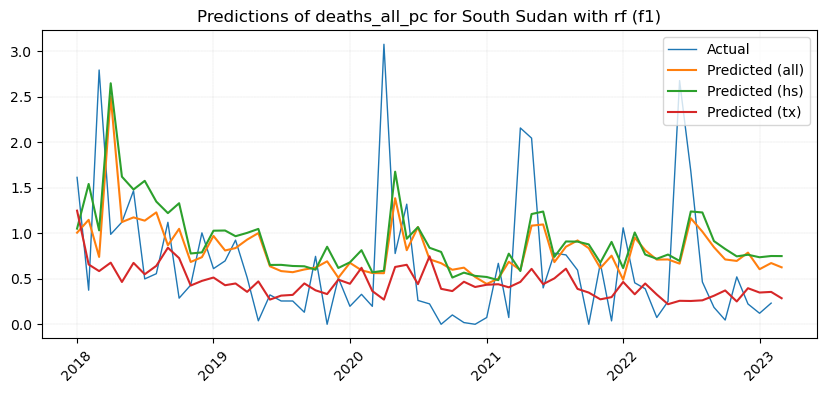

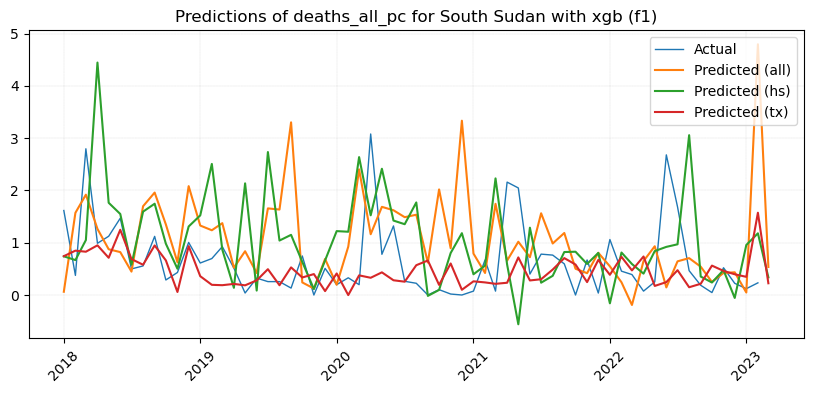

In [74]:
# plots for regression targets

for algo in algos:
    plt.figure(figsize=(10,4))

    plt.plot(country_clsf.month_year,country_clsf[f'{target_regr}_f{forward}'], linewidth=1, label = 'Actual')

    for model in ['all', 'hs', 'tx']:
        plt.plot(country_clsf.month_year,country_clsf[f'pred_{target_regr}_{algo}_f{forward}_{model}'], label = f'Predicted ({model})')

    plt.title(f'Predictions of {target_regr} for {country_name.name} with {algo} (f{forward})')
    plt.legend()
    plt.grid(color='grey', linestyle='--', linewidth=0.1)
    plt.xticks(rotation=45)
    plt.show()

## Metrics for Naive model - NEEDS to be updated

In [77]:
df.armedconf_f1.value_counts()

0.0    10962
1.0     1252
Name: armedconf_f1, dtype: int64

In [75]:
print(og_vals_clsf.shape, og_vals_regr.shape)

all_og_targets = pd.merge(og_vals_clsf, og_vals_regr, on=['month_year', 'isocode'], how='outer')
all_og_targets

NameError: name 'og_vals_clsf' is not defined

In [41]:
df_nv = all_og_targets.copy()
#cols_to_keep = ['month_year', unit_of_analyis, target_clsf, target_regr] 
#df_nv = df_nv[cols_to_keep]

fwds = [1,2]
for i in fwds:
    df_nv[f'pred_{target_clsf}_f{i}_nv'] = df_nv.groupby(unit_of_analyis)[target_clsf].shift(i)
    df_nv[f'pred_{target_regr}_f{i}_nv'] = df_nv.groupby(unit_of_analyis)[target_regr].shift(i)

df_nv.loc[df_nv['isocode'] == 'AFG']

,month_year,isocode,armedconf_intp_pop,target_clsf_f1,target_clsf_f2,deaths_all_intp_pop_pc,target_regr_f1,target_regr_f2,pred_armedconf_intp_pop_f1_nv,pred_deaths_all_intp_pop_pc_f1_nv,pred_armedconf_intp_pop_f2_nv,pred_deaths_all_intp_pop_pc_f2_nv
0,2018-01-01,AFG,True,1.0,1.0,4.838255,4.054163,3.914044,NaN,NaN,NaN,NaN
197,2018-02-01,AFG,True,1.0,1.0,4.054163,3.914044,5.273630,True,4.838255,NaN,NaN
394,2018-03-01,AFG,True,1.0,1.0,3.914044,5.273630,6.748059,True,4.054163,True,4.838255
591,2018-04-01,AFG,True,1.0,1.0,5.273630,6.748059,4.677161,True,3.914044,True,4.054163
788,2018-05-01,AFG,True,1.0,1.0,6.748059,4.677161,8.531181,True,5.273630,True,3.914044
985,2018-06-01,AFG,True,1.0,1.0,4.677161,8.531181,6.621404,True,6.748059,True,5.273630
1182,2018-07-01,AFG,True,1.0,1.0,8.531181,6.621404,6.453063,True,4.677161,True,6.748059
1379,2018-08-01,AFG,True,1.0,1.0,6.621404,6.453063,6.498871,True,8.531181,True,4.677161
1576,2018-09-01,AFG,True,1.0,1.0,6.453063,6.498871,7.627222,True,6.621404,True,8.531181
1773,2018-10-01,AFG,True,1.0,1.0,6.498871,7.627222,6.343010,True,6.453063,True,6.621404


armedconf_intp_pop f_1
ROC: 0.892 Precision: 0.665


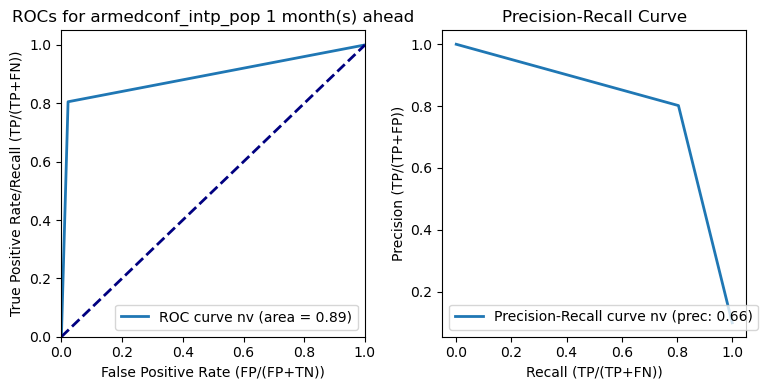

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
armedconf_intp_pop f_2
ROC: 0.856 Precision: 0.659


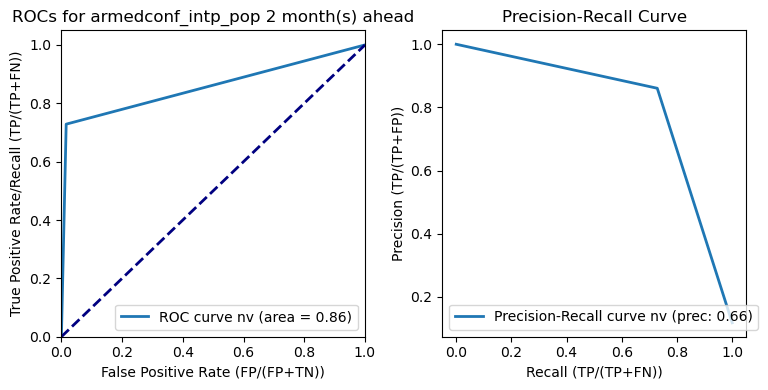

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
All Root Mean Squared Errors:
nv_1    0.394197
nv_2    0.577368
dtype: float64


In [48]:
#get_tar_pred(df_nv, 1, model: 'nv', start_time: dt, target: str, type: str):

#get_roc_pr(df_og = df_nv, fwd = 1, target: str, models: list, staryearid, binary=True, plot=True):

for target in [target_clsf]:
    for sft in [1,2]: #,2]:
        print(target, f'f_{sft}') #, model)
        get_roc_pr(df_nv, sft, target, ['nv'], start_month_year, True, True)
        print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')


errors = {}
for fwd in fwds:
#    for model in models:
            
            y_trues, y_preds = get_tar_pred(df_nv, fwd, 'nv', start_month_year, target_regr, 'regr')
        
            errors[f'nv_{fwd}'] = mean_squared_error(y_trues, y_preds)

print('All Root Mean Squared Errors:')
print(pd.Series(errors)) #.sort_values()
